# NMDA EPSP/EPSC simulation using multisynapse

In [1]:
# loading libraries
import nest
import numpy as np
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Sep 12 2022 04:40:40

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# PSC over PSP conversion
def psc_over_psp(C_m, tau_m, tau_syn):
    
    eps = tau_syn / tau_m
    PSC_over_PSP = C_m * eps**(-1/(1-eps)) / tau_m
    
    return PSC_over_PSP

Check the generated log output for any potential error messages or warnings.

The generated module is called ``nestmlmodule`` by default. It can be loaded using ``nest.Install()``:

In [3]:
nest.Install("nestmlmodule")


Feb 24 13:25:30 Install [Info]: 
    loaded module nestmlmodule


In [4]:
# simulation parameters
nest.ResetKernel()
simtime  = 500.0

In [5]:
# Neuron parameters
model_name     = 'iaf_psc_exp_multisynex'
model_params_e = {
                # Leak potential of the neurons (in mV).
                # See Allen Cells GLIF Parameters.ipynb
                'E_L': -70.0,
                # Threshold potential of the neurons (in mV).
                # See Allen Cells GLIF Parameters.ipynb
                'V_th': -45.0,
                # Membrane potential after a spike (in mV).
                # See Allen Cells GLIF Parameters.ipynb
                'V_reset': -70.0,
                # Membrane capacitance (in pF).
                # See Allen Cells GLIF Parameters.ipynb
                'C_m': 300.0,
                # Membrane time constant (in ms).
                # See Allen Cells GLIF Parameters.ipynb
                # Lowered to account for high-conductance state.
                'tau_m': 10.0,
                # Time constant of postsynaptic excitatory currents (in ms).
                # Value for AMPA receptors from (Fourcaud & Brunel, 2002)
                'tau_syn_ex_AMPA': 2.0,
                # Value for NMDA receptors
                'tau_syn_ex_NMDA': 100.0,
                # Time constant of postsynaptic inhibitory currents (in ms).
                # Value for GABA_A receptors from (Fourcaud & Brunel, 2002)
                'tau_syn_in': 2.0,
                # Refractory period of the neurons after a spike (in ms).
                't_ref': 2.0,
                # NMDA/AMPA postsynaptic current (PSC) ratio
                'r_NMDA': 2.0,
                }

In [6]:
# Synapses parameters
C_m     = model_params_e['C_m']
tau_m   = model_params_e['tau_m']
tau_syn = model_params_e['tau_syn_ex_AMPA']
    
PSP_e = 0.15
psc_e_over_psp_e = psc_over_psp(C_m, tau_m, tau_syn)
psc_e = psc_e_over_psp_e * PSP_e

# NMDA parameters
tau_syn_nmda = model_params_e['tau_syn_ex_NMDA'] # in ms
psc_nmda = model_params_e['r_NMDA']*psc_e*tau_syn/tau_syn_nmda # J_nmda = J_e*tau_s_e/tau_s_nmda

syn_dict = {"weight": psc_e,
            "receptor_type":1}

In [7]:
# Create nodes for neurons and devices
n_e = nest.Create(model_name, 1)

nest.SetStatus(n_e, model_params_e)
nest.SetStatus(n_e, {'V_m':-70.0})

# spike generator
spk_gen = nest.Create('spike_generator', params={'spike_times': [100.0]})

# create multimeter
mult = nest.Create('multimeter')
nest.SetStatus(mult, {"record_from":["V_m"]})
spk_record = nest.Create('spike_recorder')

In [8]:
# Connect neurons and devices
nest.Connect(spk_gen, n_e, "one_to_one", syn_dict)
nest.Connect(n_e, spk_record)
nest.Connect(mult, n_e)

In [9]:
# Simulation
nest.Simulate(simtime)


Feb 24 13:25:30 NodeManager::prepare_nodes [Info]: 
    Preparing 4 nodes for simulation.

Feb 24 13:25:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 500
    Number of OpenMP threads: 1
    Not using MPI

Feb 24 13:25:30 SimulationManager::run [Info]: 
    Simulation finished.


In [10]:
# Read out recording time and voltage from voltmeter
spikes = nest.GetStatus(spk_record)[0]['events']['times']
ind = nest.GetStatus(spk_record)[0]['events']['senders']

times_post = nest.GetStatus(mult)[0]['events']['times']
voltages_post = nest.GetStatus(mult)[0]['events']['V_m']

psp_max = np.max(voltages_post[0:200])-np.min(voltages_post[0:200])
print(psp_max)

0.16447633754123103


## Estimating the PSP and comparing with simulation

Considering the postsynaptic current defined as a exponential decay, then we have:

\begin{align}
I(t) = Je^{(\frac{-t-t_0}{\tau_s})}H(t-t_0)
\end{align}

where $J$ is the synaptic weight, $t_0$ is the presynaptic spike time, $\tau_s$ is the synaptic time constant, $H$ the Heaviside function ($0$ if $t<t_0$, $1$ otherwise).

Inserting this postsynaptic current in the membrane potential dynamics yields

$$
\begin{align}
\tau_m\frac{dV(t)}{dt} = -(V(t)-E_L)+RJe^{-\frac{t-t_0}{\tau_s}}H(t-t_0)
\end{align}
$$

where $V$ is the membrane potential, $E_L$ is the leak potential, $\tau_m$ is the membrane time constant, $R$ is the membrane resistance.

Solving for the membrane potential:

$$
\begin{align}
& V(t) = E_L + \tau_sRJ \frac{e^{-\frac{t-t_0}{\tau_m}}-e^{-\frac{t-t_0}{\tau_s}}}{\tau_m-\tau_s}H(t-t_0) \\\
& V(t) - E_L = PSP(t) = \tau_sRJ \frac{e^{-\frac{t-t_0}{\tau_m}}-e^{-\frac{t-t_0}{\tau_s}}}{\tau_m-\tau_s}H(t-t_0)
\end{align}
$$

Integrating the $PSP(t)$ gives

$$
\begin{align}
& \int_{-\infty}^{\infty} PSP(t)dt = \frac{\tau_sRJ}{\tau_m-\tau_s} \int_{-\infty}^{\infty} e^{-\frac{t-t_0}{\tau_m}}-e^{-\frac{t-t_0}{\tau_s}} = \tau_sRJ
\end{align}
$$

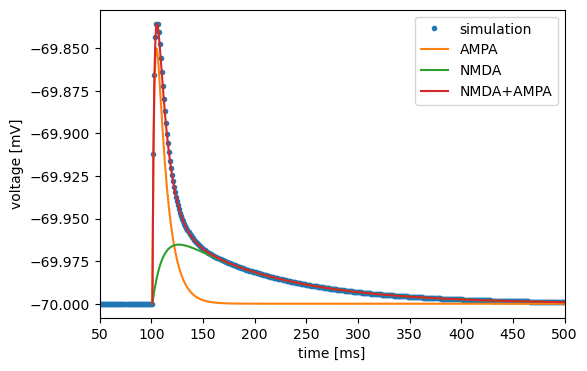

In [11]:
# plot simulated PSP and estimated PSP
R = tau_m/C_m
t = np.arange(0,simtime,1.0)

psp_est_ampa = R*psc_e*(tau_syn/(tau_syn-tau_m))*(np.exp(-t/tau_syn)-np.exp(-t/tau_m))
psp_est_nmda = R*psc_nmda*(tau_syn_nmda/(tau_syn_nmda-tau_m))*(np.exp(-t/tau_syn_nmda)-np.exp(-t/tau_m))

plt.figure(figsize=(6,4))
plt.plot(times_post, voltages_post,'.', label='simulation')
plt.plot(t+101, psp_est_ampa-70.0, label='AMPA')
plt.plot(t+101, psp_est_nmda-70.0, label='NMDA')
plt.plot(t+101, psp_est_nmda+psp_est_ampa-70.0, label='NMDA+AMPA')
plt.ylabel('voltage [mV]')
plt.xlabel('time [ms]')
plt.xlim(50,500)
plt.legend()
plt.show()

From experimental measurements we know that the mean integral of the NMDA mediated PSP should roughly be one third of the total PSP and the peak value of the NMDA mediated postsynaptic current should be around the half of the peak value of the AMPA mediated postsynaptic current. (TODO: add and check the references)

In [12]:
psc_e

33.64534757747746

In [13]:
psc_nmda

1.3458139030990983

In [14]:
meanInt_AMPA = psc_e*tau_syn*R
meanInt_AMPA

2.2430231718318305

In [15]:
meanInt_NMDA = psc_nmda*tau_syn_nmda*R
meanInt_NMDA

4.486046343663661